##**Пример расчёта**

https://github.com/lthurner/pandapower/blob/develop/tutorials/shortcircuit.ipynb

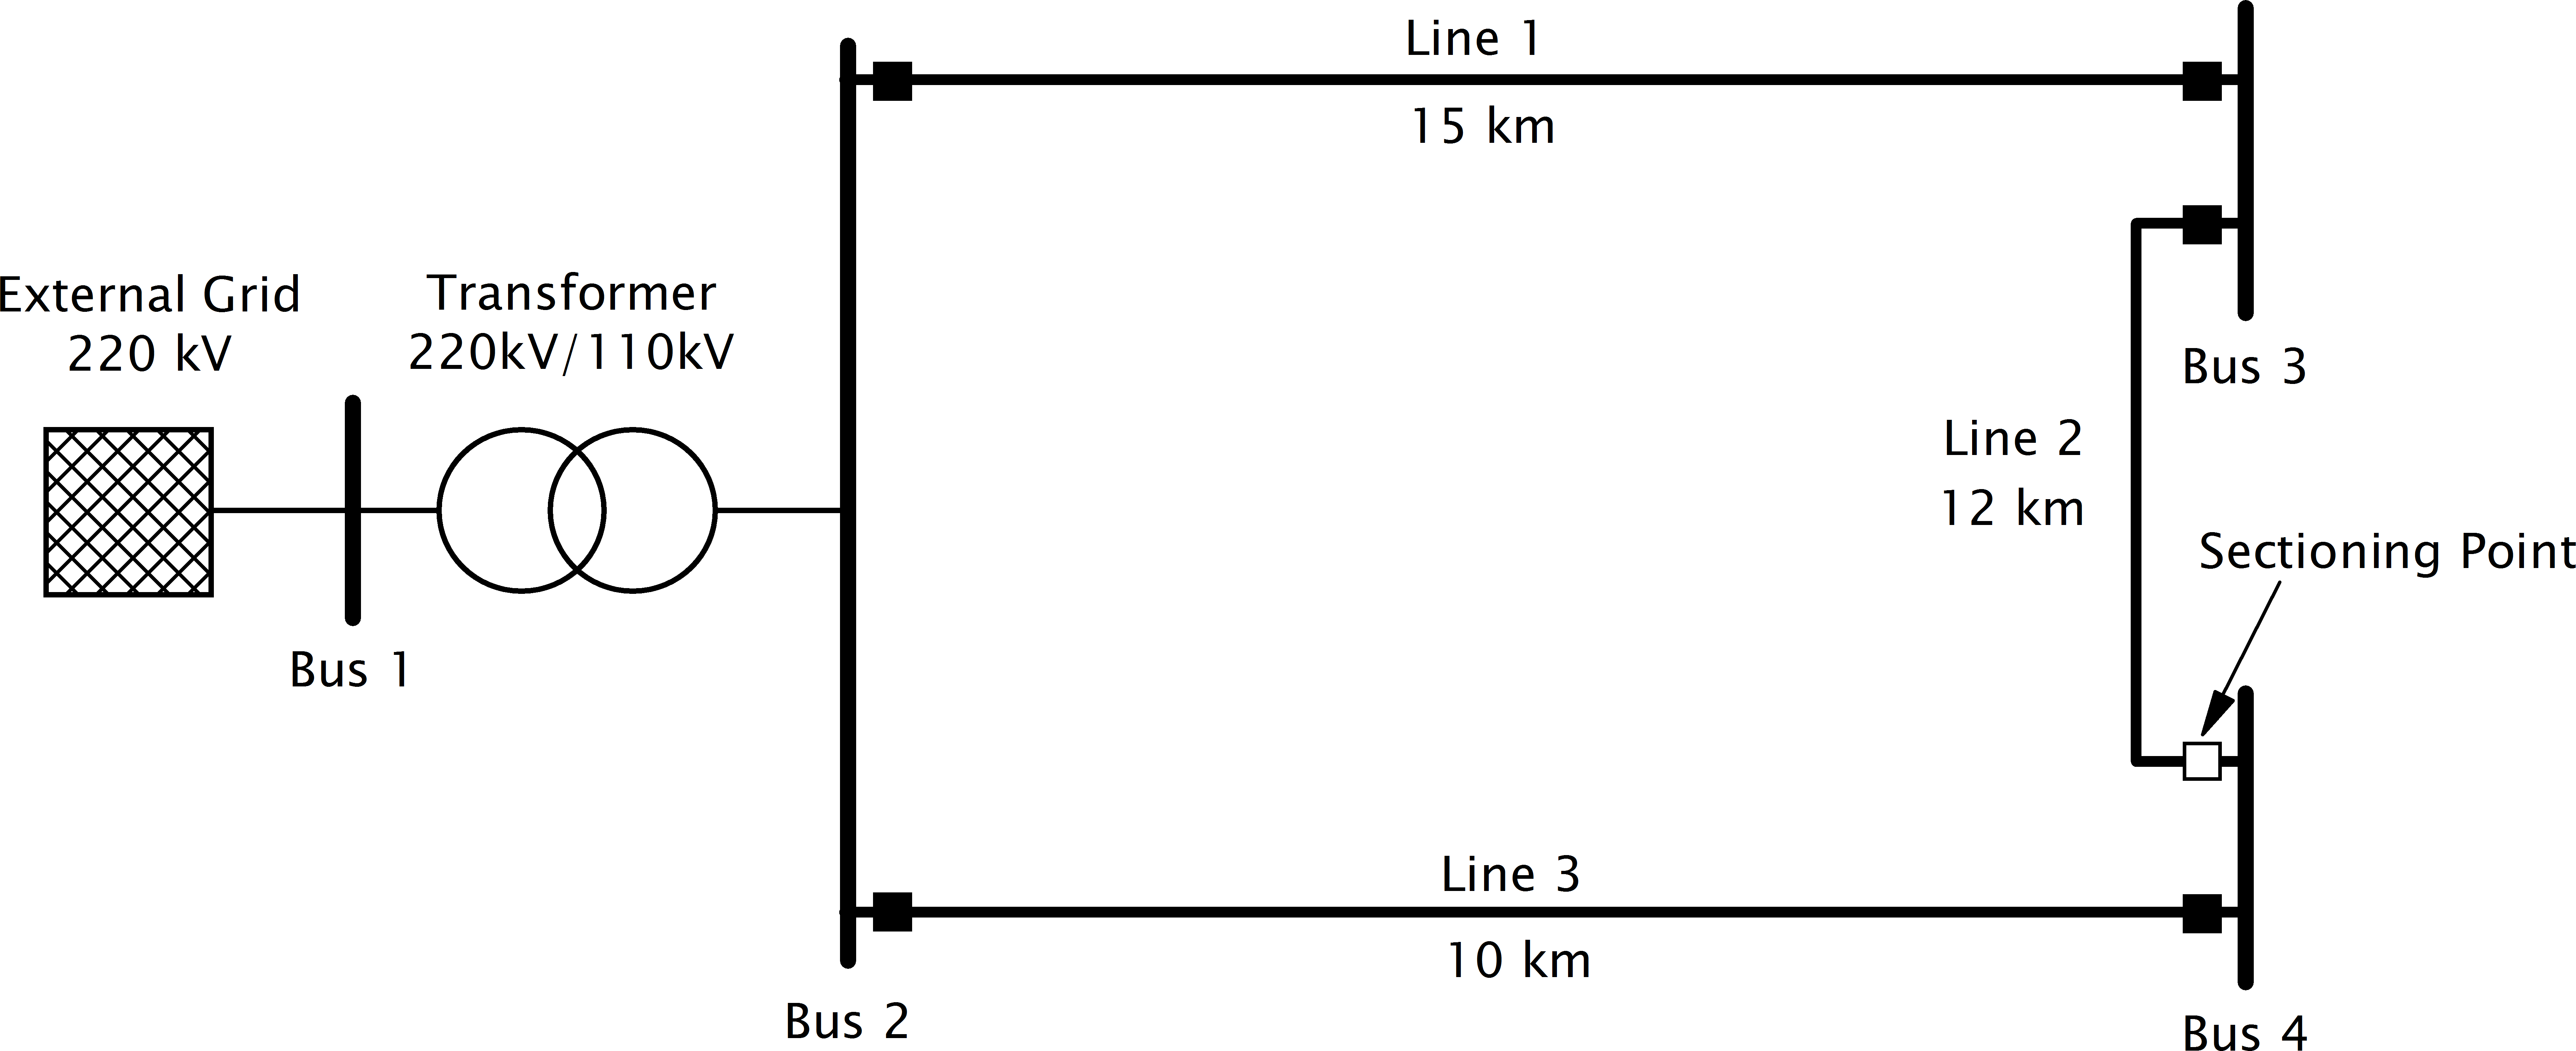

ikss (периодическая составляющая тока КЗ)\
ip (Пиковый ток КЗ)\
ith (термический ток КЗ)

In [ ]:
import pandapower as pp
import pandapower.shortcircuit as sc

def ring_network():
    net = pp.create_empty_network()
    b1 = pp.create_bus(net, 220)
    b2 = pp.create_bus(net, 110)
    b3 = pp.create_bus(net, 110)
    b4 = pp.create_bus(net, 110)
    pp.create_ext_grid(net, b1, s_sc_max_mva=100., s_sc_min_mva=80., rx_min=0.20, rx_max=0.35)
    pp.create_transformer(net, b1, b2, "100 MVA 220/110 kV")
    pp.create_line(net, b2, b3, std_type="N2XS(FL)2Y 1x120 RM/35 64/110 kV" , length_km=15.)
    l2 = pp.create_line(net, b3, b4, std_type="N2XS(FL)2Y 1x120 RM/35 64/110 kV" , length_km=12.)
    pp.create_line(net, b4, b2, std_type="N2XS(FL)2Y 1x120 RM/35 64/110 kV" , length_km=10.)
    pp.create_switch(net, b4, l2, closed=False, et="l")
    return net

Создание параметров синхронных генераторов

In [ ]:
pp.create_gen(net, 2, p_mw=0, vm_pu=1.0, cos_phi=0.8, vn_kv=22, sn_mva=5, xdss_pu=0.2, rdss_pu=0.005)
net

**Symmetric Short-Circuit Calculation**

при расчёте тока КЗ в кольцевых схемах необходимо разомкнуть один из выключателей для того, чтобы избежать уравнительных токов

*Maximum Short Circuit Currents*

In [ ]:
net = ring_network()
sc.calc_sc(net, case="max", ip=True, ith=True, branch_results=True)
net.res_bus_sc

In [ ]:
net.res_line_sc

In [ ]:
net.res_trafo_sc

*Minimum Short Circuit Currents*

In [ ]:
net = ring_network()
net.line["endtemp_degree"] = 80
sc.calc_sc(net, case="min", ith=True, ip=True, branch_results=True)
net.res_bus_sc

In [ ]:
net.res_line_sc

In [ ]:
net.res_trafo_sc

**Asymetrical Two-Phase Short-Circuit Calculation**

In [ ]:
net = ring_network()
sc.calc_sc(net, fault="2ph", ip=True, ith=True)
net.res_bus_sc

NameError: name 'ring_network' is not defined

In [ ]:
net = ring_network()
net.line["endtemp_degree"] = 150
sc.calc_sc(net, fault="2ph", case="min", ip=True, ith=True)
net.res_bus_sc

NameError: name 'ring_network' is not defined

Библиотека Matplotlib

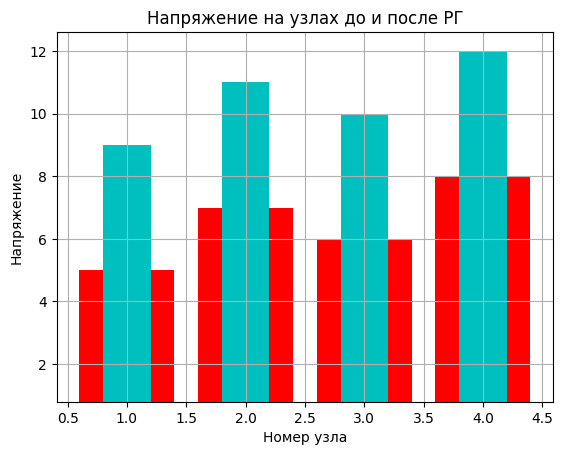

In [ ]:
#пример кода визуализации с помощью гистограмм с наложением
import matplotlib.pyplot as plt

x1 = [1,2,3,4]
y1 = [5,7,6,8]
x2 = [1,2,3,4]
y2 = [9,11,10,12]

fig, ax = plt.subplots()

U1 = ax.bar(x1, y1, color = 'r', width = 0.8)
U2 = ax.bar(x2, y2, color = 'c', width = 0.4)
plt.ylim(bottom=0.8)
plt.title("Напряжение на узлах до и после РГ")
plt.xlabel("Номер узла")
plt.ylabel("Напряжение")
plt.grid()
plt.show()

##**Решение**

*Исходные данные*
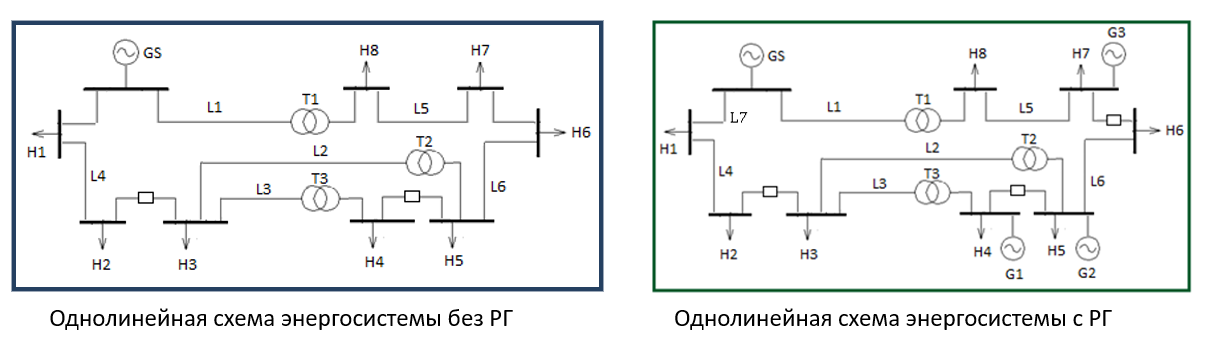



In [ ]:
pip install --upgrade pandapower

In [ ]:
# Подключение библиотек
import pandapower as pp
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import pandapower.shortcircuit as sc

Функция с исходной моделью

In [ ]:
def network(com):

  # Создание пустой сети
  net2 = pp.create_empty_network()

  # Создание узлов
  busGS=pp.create_bus(net2, name='generator', vn_kv=110)
  bus1=pp.create_bus(net2, name='H1', vn_kv=110)
  bus2=pp.create_bus(net2, name='H2', vn_kv=110)
  bus3=pp.create_bus(net2, name='H3', vn_kv=110)
  bus4=pp.create_bus(net2, name='H4', vn_kv=10)
  bus5=pp.create_bus(net2, name='H5', vn_kv=10)
  bus6=pp.create_bus(net2, name='H6', vn_kv=10)
  bus7=pp.create_bus(net2, name='H7', vn_kv=10)
  bus8=pp.create_bus(net2, name='H8', vn_kv=10)

  # Создание создание дополнительных узлов для трансформаторов
  busGS8=pp.create_bus(net2, name='HGS8', vn_kv=110)
  bus35=pp.create_bus(net2, name='H35', vn_kv=110)
  bus34=pp.create_bus(net2, name='H34', vn_kv=110)

  # Создание энергосистемы, функция была дополнена следующими параметрами:
  # s_sc_max_mva - Мощность короткого замыкания для максимального режима
  # s_sc_min_mva - Мощность короткого замыкания для минимального режима
  # rx_min - Отношение R/X для минимального режима КЗ
  # rx_max - Отношение R/X для максимального режима КЗ
  pp.create_ext_grid(net2, bus = busGS, s_sc_max_mva=100., s_sc_min_mva=80., rx_min=0.20, rx_max=0.35, vm_pu= 1.02)

  # Создание нагрузок
  pp.create_load(net2, bus = bus1, p_mw= 17, q_mvar= 11.2)
  pp.create_load(net2, bus = bus2, p_mw= 31, q_mvar= 24)
  pp.create_load(net2, bus = bus3, p_mw= 21.5, q_mvar= 23)
  pp.create_load(net2, bus = bus4, p_mw= 4, q_mvar= 4)
  pp.create_load(net2, bus = bus5, p_mw= 2, q_mvar= 1)
  pp.create_load(net2, bus = bus6, p_mw= 3, q_mvar= 2)
  pp.create_load(net2, bus = bus7, p_mw= 3, q_mvar= 1)
  pp.create_load(net2, bus = bus8, p_mw= 4.5, q_mvar= 4.5)

  # Создание электрических лиинй
  line1=pp.create_line_from_parameters(net2, from_bus=busGS, to_bus=busGS8, name='L1',length_km=6.1, r_ohm_per_km=0.429,
                                    x_ohm_per_km=0.44, max_i_ka= 0.265, c_nf_per_km=0)
  line2=pp.create_line_from_parameters(net2, from_bus=bus3, to_bus=bus35, name='L2', length_km=9.6, r_ohm_per_km=0.429,
                                    x_ohm_per_km=0.44, max_i_ka= 0.265, c_nf_per_km=0)
  line3=pp.create_line_from_parameters(net2, from_bus=bus3, to_bus=bus34, name='L3', length_km=8.7, r_ohm_per_km=0.429,
                                    x_ohm_per_km=0.44, max_i_ka= 0.265, c_nf_per_km=0)
  line4=pp.create_line_from_parameters(net2, from_bus=bus1, to_bus=bus2, name='L4', length_km=1.4, r_ohm_per_km=0.301,
                                    x_ohm_per_km=0.429, max_i_ka= 0.33, c_nf_per_km=0)
  line5=pp.create_line_from_parameters(net2, from_bus=bus8, to_bus=bus7, name='L5', length_km=1.1, r_ohm_per_km=0.11,
                                    x_ohm_per_km=0.193, max_i_ka= 0.610, c_nf_per_km=0)
  line6=pp.create_line_from_parameters(net2, from_bus=bus5, to_bus=bus6, name='L6', length_km=1.3, r_ohm_per_km=0.157,
                                    x_ohm_per_km=0.416, max_i_ka= 0.52, c_nf_per_km=0)
  line7=pp.create_line_from_parameters(net2, from_bus=busGS, to_bus=bus1, name='L7', length_km=1.2, r_ohm_per_km=0.301,
                                    x_ohm_per_km=0.429, max_i_ka= 0.33, c_nf_per_km=0)

  # Создание выключателей
  sw1 = pp.create_switch(net2, bus2, bus3, et="b", type="CB", closed=True)
  sw2 = pp.create_switch(net2, bus4, bus5, et="b", type="CB", closed=True)
  sw3 = pp.create_switch(net2, bus6, bus7, et="b", type="CB", closed=False)

  # Создание трансформаторов
  transformator1 = pp.create_transformer_from_parameters(net2, hv_bus=busGS8, lv_bus=bus8, name='T1', sn_mva = 32, vn_hv_kv = 110, vn_lv_kv = 10, vk_percent = 10.5, i0_percent = 0.28, pfe_kw = 160, vkr_percent = (160/320))
  transformator2 = pp.create_transformer_from_parameters(net2, hv_bus=bus35, lv_bus=bus5, name='T2', sn_mva = 40, vn_hv_kv = 110, vn_lv_kv = 10, vk_percent = 10.5, i0_percent = 0.28, pfe_kw = 160, vkr_percent = (160/400))
  transformator3 = pp.create_transformer_from_parameters(net2, hv_bus=bus34, lv_bus=bus4, name='T3', sn_mva = 40, vn_hv_kv = 110, vn_lv_kv = 10, vk_percent = 10.5, i0_percent = 0.28, pfe_kw = 160, vkr_percent = (160/400))

  # Создание конденсаторных батарей
  #cap1 = pp.create_shunt_as_capacitor(net2, bus=bus4, q_mvar = -4 * Com1, loss_factor=0, in_service = Com2[0])
  #cap2 = pp.create_shunt_as_capacitor(net2, bus=bus5, q_mvar = -1 * Com1, loss_factor=0, in_service = Com2[1])
  #cap3 = pp.create_shunt_as_capacitor(net2, bus=bus7, q_mvar = -1 * Com1, loss_factor=0, in_service = Com2[2])

  # Создание генераторов
  if com == 1:
    pp.create_gen(net2, bus = bus4, p_mw = 1.2, vm_pu = 1.02, cos_phi=0.8, vn_kv=10, sn_mva=5, xdss_pu=0.2, rdss_pu=0.005, rdss_ohm = 0.1)
    pp.create_gen(net2, bus = bus4, p_mw = 1.2, vm_pu = 1.02, cos_phi=0.8, vn_kv=10, sn_mva=5, xdss_pu=0.2, rdss_pu=0.005, rdss_ohm = 0.1)
    pp.create_gen(net2, bus = bus5, p_mw = 1.4, vm_pu = 1.02, cos_phi=0.8, vn_kv=10, sn_mva=5, xdss_pu=0.2, rdss_pu=0.005, rdss_ohm = 0.1)
    pp.create_gen(net2, bus = bus7, p_mw = 2.75, vm_pu = 1.02, cos_phi=0.8, vn_kv=10, sn_mva=5, xdss_pu=0.2, rdss_pu=0.005, rdss_ohm = 0.1)
    #pp.create_gen(net, 2, p_mw=0, vm_pu=1.0, cos_phi=0.8, vn_kv=22, sn_mva=5, xdss_pu=0.2, rdss_pu=0.005) из примера на GITHUB

  return net2



**Расчёт трехфазного КЗ**

*максимальная мощность КЗ*

In [ ]:
#Размыкаю выключатель между шинами 6 и 7 БЕЗ РГ
net = network(0)
sc.calc_sc(net, case="max", ip=True, ith=True, branch_results=True)
net.res_bus_sc

/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)
/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)


,ikss_ka,skss_mw,ip_ka,ith_ka,rk_ohm,xk_ohm
0,0.524864,100.000000,1.011668,0.527447,43.969642,125.627547
1,0.522488,99.547266,1.005999,0.525049,44.330842,126.142347
2,0.519741,99.024028,0.999465,0.522277,44.752242,126.742947
3,0.519741,99.024028,0.999465,0.522277,44.752242,126.742947
4,5.058551,87.616666,9.919930,5.085098,0.390980,1.193037
5,5.058551,87.616666,9.919930,5.085098,0.390980,1.193037
6,3.464514,60.007149,6.712373,3.481893,0.595080,1.733837
7,3.784766,65.554065,7.426858,3.804678,0.521374,1.594951
8,4.411994,76.417971,8.929365,4.438134,0.400374,1.382651
9,0.511764,97.504163,0.976872,0.514194,46.586542,128.311547


In [ ]:
net.res_line_sc

,ikss_ka,ikss_from_ka,ikss_from_degree,ikss_to_ka,ikss_to_degree,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,ip_ka,ith_ka
0,0.511764,0.511764,-70.045374,0.511764,109.954626,6.789305,23.923539,0.0,-0.0,0.439952,0.520631,0.439952,0.520631,0.976872,0.514194
1,0.467712,0.467712,-66.721050,0.467712,113.278950,4.086021,12.261511,0.0,-0.0,0.433481,0.776279,0.420446,1.639880,0.890484,0.469912
2,0.472303,0.472303,-67.080406,0.472303,112.919594,4.024093,12.453852,0.0,-0.0,0.433481,0.776279,0.421570,1.581572,0.899662,0.474529
3,0.519741,0.519741,-70.552152,0.519741,109.447848,8.235518,24.894096,0.0,-0.0,0.436964,0.637681,0.433481,0.776279,0.999465,0.522277
4,3.784766,3.784766,-71.897923,3.784766,108.102077,5.199776,9.123243,0.0,-0.0,0.439952,0.520631,0.439952,0.520631,7.426858,3.804678
5,3.464514,3.464514,-71.056959,3.464514,108.943041,7.349351,19.473440,0.0,-0.0,0.379355,2.258567,0.379355,2.258567,6.712373,3.481893
6,0.522488,0.522488,-70.636738,0.522488,109.363262,8.343008,25.047296,0.0,-0.0,0.439952,0.520631,0.436964,0.637681,1.005999,0.525049


In [ ]:
net.res_trafo_sc

,ikss_hv_ka,ikss_hv_degree,ikss_lv_ka,ikss_lv_degree,p_hv_mw,q_hv_mvar,p_lv_mw,q_lv_mvar,vm_hv_pu,va_hv_degree,vm_lv_pu,va_lv_degree
0,0.401090,-73.850567,4.411994,106.149433,5.859909,22.970312,0.000000,-0.000000,0.439952,0.520631,0.439952,0.520631
1,0.228492,-71.591707,2.513409,108.408293,3.783453,11.951184,0.006141,0.161083,0.420446,1.639880,0.379355,2.258567
2,0.231381,-72.115123,2.545194,107.884877,3.742911,12.165461,0.005077,0.133175,0.421570,1.581572,0.379355,2.258567


In [ ]:
#Ток при максимальной мощности 3Ф КЗ без РГ
print(net.res_bus_sc.ikss_ka)

0     0.524864
1     0.522488
2     0.519741
3     0.519741
4     5.058551
5     5.058551
6     3.464514
7     3.784766
8     4.411994
9     0.511764
10    0.500630
11    0.502291
Name: ikss_ka, dtype: float64


In [ ]:
#Размыкаю выключатель между шинами 6 и 7 С РГ
net = network(1)
sc.calc_sc(net, case="max", ip=True, ith=True, branch_results=True)
net.res_bus_sc

/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)
/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)


,ikss_ka,skss_mw,ip_ka,ith_ka,rk_ohm,xk_ohm
0,1.036198,197.422189,2.313086,1.045620,12.813369,66.190140
1,1.033580,196.923345,2.308400,1.043001,12.843258,66.358310
2,1.030575,196.350892,2.303160,1.039999,12.874994,66.552879
3,1.030575,196.350892,2.303160,1.039999,12.874994,66.552879
4,10.843775,187.819692,24.883890,10.957616,0.092835,0.578264
5,10.843775,187.819692,24.883890,10.957616,0.092835,0.578264
6,5.485332,95.008736,11.363665,5.521021,0.296935,1.119064
7,6.822038,118.161161,15.176088,6.883020,0.176552,0.914037
8,8.000720,138.576539,18.515770,8.088763,0.119142,0.784793
9,1.000023,190.530012,2.188691,1.008292,14.675383,68.298901


In [ ]:
net.res_line_sc

,ikss_ka,ikss_from_ka,ikss_from_degree,ikss_to_ka,ikss_to_degree,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,ip_ka,ith_ka
0,0.872713,0.872713,-76.529105,0.872713,103.470895,12.988787,45.768708,1.372372,6.518987,0.629786,-3.628247,0.632539,-3.787244,1.910055,0.879929
1,0.733568,0.733568,-71.851392,0.733568,108.148608,6.915033,14.977364,1.658408,10.383825,0.623893,-3.528563,0.611756,-3.125676,1.621170,0.739919
2,0.740645,0.740645,-72.170456,0.740645,107.829544,6.863637,15.230106,1.626776,10.514688,0.623893,-3.528563,0.612790,-3.149943,1.638154,0.747083
3,0.641660,0.641660,-73.608770,0.641660,106.391230,13.877299,30.348042,2.443379,20.641769,0.627066,-3.582472,0.623893,-3.528563,1.434000,0.647527
4,5.234927,5.234927,-76.146946,5.234927,103.853054,9.947819,17.453900,1.746485,7.111894,0.666103,-3.322070,0.690590,-3.991037,11.645451,5.281722
5,5.485332,5.485332,-75.139448,5.485332,104.860552,18.423413,48.816177,0.000000,-0.000000,0.586362,-2.405786,0.586362,-2.405786,11.363665,5.521021
6,0.645781,0.645781,-73.733123,0.645781,106.266877,13.961839,30.468531,2.262536,20.565124,0.629786,-3.628247,0.627066,-3.582472,1.442290,0.651668


In [ ]:
net.res_trafo_sc

,ikss_hv_ka,ikss_hv_degree,ikss_lv_ka,ikss_lv_degree,p_hv_mw,q_hv_mvar,p_lv_mw,q_lv_mvar,vm_hv_pu,va_hv_degree,vm_lv_pu,va_lv_degree
0,0.588928,-80.045231,6.478205,99.954769,11.210735,43.945066,1.389411,6.876406,0.632539,-3.787244,0.666103,-3.322070
1,0.274353,-74.485908,3.017881,105.514092,6.677067,14.733297,1.784436,11.366871,0.611756,-3.125676,0.586362,-2.405786
2,0.277822,-75.009324,3.056046,104.990676,6.642492,15.003291,1.756012,11.522754,0.612790,-3.149943,0.586362,-2.405786


In [ ]:
#Ток при максимальной мощности 3Ф КЗ c РГ
print(net.res_bus_sc.ikss_ka)

0      1.036198
1      1.033580
2      1.030575
3      1.030575
4     10.843775
5     10.843775
6      5.485332
7      6.822038
8      8.000720
9      1.000023
10     0.985809
11     0.989721
Name: ikss_ka, dtype: float64


*минимальная мощность КЗ*

In [ ]:
#Размыкаю выключатель между шинами 6 и 7 БЕЗ РГ
net = network(0)

#Конечная температура проводника после короткого замыкания
net.line['endtemp_degree'] = 80

sc.calc_sc(net, case="min", ip=True, ith=True, branch_results=True)
net.res_bus_sc

/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)
/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)


,ikss_ka,skss_mw,ip_ka,ith_ka,rk_ohm,xk_ohm
0,0.419891,80.000000,0.925067,0.423473,29.662565,148.312827
1,0.418251,79.687563,0.919250,0.421778,30.110453,148.827627
2,0.416352,79.325632,0.912553,0.419817,30.632989,149.428227
3,0.416352,79.325632,0.912553,0.419817,30.632989,149.428227
4,4.099716,71.009167,9.018131,4.134429,0.278183,1.380520
5,4.099716,71.009167,9.018131,4.134429,0.278183,1.380520
6,2.896283,50.165095,5.929044,2.914239,0.531267,1.921320
7,3.145797,54.486794,6.626026,3.167731,0.437364,1.782432
8,3.617018,62.648594,8.112699,3.650700,0.287324,1.570132
9,0.410949,78.296332,0.888993,0.414170,32.907521,150.996827


In [ ]:
net.res_line_sc

,ikss_ka,ikss_from_ka,ikss_from_degree,ikss_to_ka,ikss_to_degree,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,ip_ka,ith_ka
0,0.285982,0.285982,-76.213428,0.285982,103.786572,0.0,-0.0,-4.910456,-15.869021,0.0,0.0,0.0,0.0,0.888993,0.414170
1,0.033949,0.033949,-117.872255,0.033949,62.127745,0.0,-0.0,-3.263042,-8.342950,0.0,0.0,0.0,0.0,0.805881,0.378200
2,0.037349,0.037349,-117.773448,0.037349,62.226552,0.0,-0.0,-3.229621,-8.511533,0.0,0.0,0.0,0.0,0.814718,0.381884
3,0.263298,0.263298,-74.543269,0.263298,105.456731,0.0,-0.0,-6.998533,-17.272903,0.0,0.0,0.0,0.0,0.912553,0.419817
4,3.145797,3.145797,-76.213428,3.145797,103.786572,0.0,-0.0,0.000000,-0.000000,0.0,0.0,0.0,0.0,6.626026,3.167731
5,2.896283,2.896283,-74.543269,2.896283,105.456731,0.0,-0.0,0.000000,-0.000000,0.0,0.0,0.0,0.0,5.929044,2.914239
6,0.263298,0.263298,-74.543269,0.263298,105.456731,0.0,-0.0,-7.107209,-17.397815,0.0,0.0,0.0,0.0,0.919250,0.421778


In [ ]:
net.res_trafo_sc

,ikss_hv_ka,ikss_hv_degree,ikss_lv_ka,ikss_lv_degree,p_hv_mw,q_hv_mvar,p_lv_mw,q_lv_mvar,vm_hv_pu,va_hv_degree,vm_lv_pu,va_lv_degree
0,0.285982,-76.213428,3.145797,103.786572,0.0,-0.0,-4.454404,-6.302785,0.0,0.0,0.0,0.0
1,0.033949,-117.872255,0.373438,62.127745,0.0,0.0,-3.202002,-6.741819,0.0,0.0,0.0,0.0
2,0.033949,62.127745,0.373438,-117.872255,0.0,0.0,-3.166950,-6.867612,0.0,0.0,0.0,0.0


In [ ]:
#Ток при минимальной мощности 3Ф КЗ без РГ
print(net.res_bus_sc.ikss_ka)

0     0.419891
1     0.418251
2     0.416352
3     0.416352
4     4.099716
5     4.099716
6     2.896283
7     3.145797
8     3.617018
9     0.410949
10    0.402904
11    0.404109
Name: ikss_ka, dtype: float64


In [ ]:
#Размыкаю выключатель между шинами 6 и 7 С РГ
net = network(1)

#Конечная температура проводника после короткого замыкания
net.line['endtemp_degree'] = 80

sc.calc_sc(net, case="min", ip=True, ith=True, branch_results=True)
net.res_bus_sc

/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)
/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)


,ikss_ka,skss_mw,ip_ka,ith_ka,rk_ohm,xk_ohm
0,0.892296,170.005141,2.106381,0.903335,8.452045,70.670690
1,0.890607,169.683476,2.101484,0.901597,8.509309,70.799715
2,0.888662,169.312930,2.096021,0.899600,8.572240,70.949322
3,0.888662,169.312930,2.096021,0.899600,8.572240,70.949322
4,9.456169,163.785651,22.628431,9.583776,0.063955,0.607195
5,9.456169,163.785651,22.628431,9.583776,0.063955,0.607195
6,4.847736,83.965253,9.844162,4.876840,0.317039,1.147995
7,6.033426,104.502000,13.485768,6.088643,0.166472,0.942328
8,7.029812,121.759912,16.757096,7.122303,0.092149,0.816102
9,0.864086,164.630582,1.977314,0.873020,10.782587,72.702650


In [ ]:
net.res_line_sc

,ikss_ka,ikss_from_ka,ikss_from_degree,ikss_to_ka,ikss_to_degree,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,ip_ka,ith_ka
0,0.051542,0.051542,103.463109,0.051542,-76.536891,-2.006229,-5.224894,-10.435786,-33.725117,0.0,0.0,0.0,0.0,1.709882,0.754944
1,0.095590,0.095590,98.369753,0.095590,-81.630247,-2.209958,-8.303988,-5.555058,-11.070291,0.0,0.0,0.0,0.0,1.436105,0.628827
2,0.096859,0.096859,97.720993,0.096859,-82.279007,-2.143879,-8.439034,-5.516916,-11.297154,0.0,0.0,0.0,0.0,1.451841,0.634765
3,0.192446,0.192446,98.043234,0.192446,-81.956766,-4.295780,-16.676292,-11.480176,-22.705081,0.0,0.0,0.0,0.0,1.250550,0.536729
4,0.566963,0.566963,103.463109,0.566963,-76.536891,-2.046904,-5.557020,0.000000,-0.000000,0.0,0.0,0.0,0.0,10.250476,4.627951
5,4.847736,4.847736,-74.561579,4.847736,105.438421,0.000000,-0.000000,0.000000,-0.000000,0.0,0.0,0.0,0.0,9.844162,4.876840
6,0.192446,0.192446,98.043234,0.192446,-81.956766,-4.246017,-16.619094,-11.567870,-22.805876,0.0,0.0,0.0,0.0,1.258232,0.539817


In [ ]:
net.res_trafo_sc

,ikss_hv_ka,ikss_hv_degree,ikss_lv_ka,ikss_lv_degree,p_hv_mw,q_hv_mvar,p_lv_mw,q_lv_mvar,vm_hv_pu,va_hv_degree,vm_lv_pu,va_lv_degree
0,0.051542,103.463109,0.566963,-76.536891,-2.032091,-5.246285,-9.466575,-13.394788,0.0,0.0,0.0,0.0
1,0.095590,98.369753,1.051490,-81.630247,-2.349948,-8.419778,-5.505803,-9.778291,0.0,0.0,0.0,0.0
2,0.096859,97.720993,1.065448,-82.279007,-2.274135,-8.546773,-5.466345,-9.970626,0.0,0.0,0.0,0.0


In [ ]:
#Ток при минимальной мощности 3Ф КЗ с РГ
print(net.res_bus_sc.ikss_ka)

0     0.892296
1     0.890607
2     0.888662
3     0.888662
4     9.456169
5     9.456169
6     4.847736
7     6.033426
8     7.029812
9     0.864086
10    0.853159
11    0.856327
Name: ikss_ka, dtype: float64


Расчёт двухфазного КЗ

*максимальная мощность КЗ*

In [ ]:
#Размыкаю выключатель между шинами 6 и 7 БЕЗ РГ
net = network(0)
sc.calc_sc(net, fault="2ph", case="max", ip=True, ith=True, branch_results=True)
net.res_bus_sc

/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)
/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)


,ikss_ka,skss_mw,ip_ka,ith_ka,rk_ohm,xk_ohm
0,0.454545,28.867513,0.876130,0.456782,43.969642,125.627547
1,0.452488,28.736820,0.871221,0.454705,44.330842,126.142347
2,0.450109,28.585775,0.865562,0.452305,44.752242,126.742947
3,0.450109,28.585775,0.865562,0.452305,44.752242,126.742947
4,4.380833,25.292753,8.590911,4.403824,0.390980,1.193037
5,4.380833,25.292753,8.590911,4.403824,0.390980,1.193037
6,3.000357,17.322572,5.813086,3.015408,0.595080,1.733837
7,3.277703,18.923829,6.431848,3.294947,0.521374,1.594951
8,3.820899,22.059968,7.733057,3.843537,0.400374,1.382651
9,0.443201,28.147027,0.845996,0.445305,46.586542,128.311547


In [ ]:
net.res_line_sc

,ikss_ka,ikss_from_ka,ikss_from_degree,ikss_to_ka,ikss_to_degree,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,ip_ka,ith_ka
0,0.443201,0.443201,NaN,0.443201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.845996,0.445305
1,0.405051,0.405051,NaN,0.405051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.771182,0.406956
2,0.409027,0.409027,NaN,0.409027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.779131,0.410954
3,0.450109,0.450109,NaN,0.450109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.865562,0.452305
4,3.277703,3.277703,NaN,3.277703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.431848,3.294947
5,3.000357,3.000357,NaN,3.000357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.813086,3.015408
6,0.452488,0.452488,NaN,0.452488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.871221,0.454705


In [ ]:
net.res_trafo_sc

,ikss_hv_ka,ikss_hv_degree,ikss_lv_ka,ikss_lv_degree,p_hv_mw,q_hv_mvar,p_lv_mw,q_lv_mvar,vm_hv_pu,va_hv_degree,vm_lv_pu,va_lv_degree
0,0.347354,NaN,3.820899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.197880,NaN,2.176676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.200382,NaN,2.204203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Ток при максимальной мощности 2Ф КЗ БЕЗ РГ
print(net.res_bus_sc.ikss_ka)

0     0.454545
1     0.452488
2     0.450109
3     0.450109
4     4.380833
5     4.380833
6     3.000357
7     3.277703
8     3.820899
9     0.443201
10    0.433558
11    0.434997
Name: ikss_ka, dtype: float64


In [ ]:
#Размыкаю выключатель между шинами 6 и 7 С РГ
net = network(1)
sc.calc_sc(net, fault="2ph", case="max", ip=True, ith=True, branch_results=True)
net.res_bus_sc

/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)
/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)


,ikss_ka,skss_mw,ip_ka,ith_ka,rk_ohm,xk_ohm
0,0.897374,56.990877,2.003191,0.905533,12.813369,66.190140
1,0.895106,56.846873,1.999133,0.903266,12.843258,66.358310
2,0.892504,56.681620,1.994595,0.900666,12.874994,66.552879
3,0.892504,56.681620,1.994595,0.900666,12.874994,66.552879
4,9.390985,54.218875,21.550081,9.489573,0.092835,0.578264
5,9.390985,54.218875,21.550081,9.489573,0.092835,0.578264
6,4.750437,27.426660,9.841223,4.781345,0.296935,1.119064
7,5.908058,34.110189,13.142877,5.960870,0.176552,0.914037
8,6.928827,40.003601,16.035127,7.005074,0.119142,0.784793
9,0.866046,55.001277,1.895462,0.873207,14.675383,68.298901


In [ ]:
net.res_line_sc

,ikss_ka,ikss_from_ka,ikss_from_degree,ikss_to_ka,ikss_to_degree,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,ip_ka,ith_ka
0,0.755792,0.755792,NaN,0.755792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.654156,0.762041
1,0.635289,0.635289,NaN,0.635289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.403975,0.640789
2,0.641418,0.641418,NaN,0.641418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.418683,0.646993
3,0.555693,0.555693,NaN,0.555693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.241881,0.560775
4,4.533580,4.533580,NaN,4.533580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.085256,4.574105
5,4.750437,4.750437,NaN,4.750437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.841223,4.781345
6,0.559263,0.559263,NaN,0.559263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.249060,0.564361


In [ ]:
net.res_trafo_sc

,ikss_hv_ka,ikss_hv_degree,ikss_lv_ka,ikss_lv_degree,p_hv_mw,q_hv_mvar,p_lv_mw,q_lv_mvar,vm_hv_pu,va_hv_degree,vm_lv_pu,va_lv_degree
0,0.510026,NaN,5.610290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.237597,NaN,2.613562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.240601,NaN,2.646613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Ток при максимальной мощности 2Ф КЗ с РГ
print(net.res_bus_sc.ikss_ka)

0     0.897374
1     0.895106
2     0.892504
3     0.892504
4     9.390985
5     9.390985
6     4.750437
7     5.908058
8     6.928827
9     0.866046
10    0.853736
11    0.857124
Name: ikss_ka, dtype: float64


*минимальная мощность КЗ*

In [ ]:
#Размыкаю выключатель между шинами 6 и 7 без РГ
net = network(0)

#Конечная температура проводника после короткого замыкания
net.line['endtemp_degree'] = 80

sc.calc_sc(net, fault="2ph", case="min", ip=True, ith=True, branch_results=True)
net.res_bus_sc

/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)
/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)


,ikss_ka,skss_mw,ip_ka,ith_ka,rk_ohm,xk_ohm
0,0.363636,23.094011,0.801132,0.366738,29.662565,148.312827
1,0.362216,23.003818,0.796094,0.365271,30.110453,148.827627
2,0.360571,22.899337,0.790294,0.363573,30.632989,149.428227
3,0.360571,22.899337,0.790294,0.363573,30.632989,149.428227
4,3.550458,20.498581,7.809931,3.580521,0.278183,1.380520
5,3.550458,20.498581,7.809931,3.580521,0.278183,1.380520
6,2.508255,14.481415,5.134703,2.523805,0.531267,1.921320
7,2.724340,15.728983,5.738307,2.743335,0.437364,1.782432
8,3.132430,18.085091,7.025803,3.161599,0.287324,1.570132
9,0.355892,22.602204,0.769891,0.358682,32.907521,150.996827


In [ ]:
net.res_line_sc

,ikss_ka,ikss_from_ka,ikss_from_degree,ikss_to_ka,ikss_to_degree,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,ip_ka,ith_ka
0,0.247667,0.247667,NaN,0.247667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.521664,0.249394
1,0.029401,0.029401,NaN,0.029401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.063202,0.029625
2,0.032345,0.032345,NaN,0.032345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069445,0.032590
3,0.228023,0.228023,NaN,0.228023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.466791,0.229437
4,2.724340,2.724340,NaN,2.724340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.738307,2.743335
5,2.508255,2.508255,NaN,2.508255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.134703,2.523805
6,0.228023,0.228023,NaN,0.228023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.466791,0.229437


In [ ]:
net.res_trafo_sc

,ikss_hv_ka,ikss_hv_degree,ikss_lv_ka,ikss_lv_degree,p_hv_mw,q_hv_mvar,p_lv_mw,q_lv_mvar,vm_hv_pu,va_hv_degree,vm_lv_pu,va_lv_degree
0,0.247667,NaN,2.724340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.029401,NaN,0.323407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.029401,NaN,0.323407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Ток при минимальной мощности 2Ф КЗ без РГ
print(net.res_bus_sc.ikss_ka)

0     0.363636
1     0.362216
2     0.360571
3     0.360571
4     3.550458
5     3.550458
6     2.508255
7     2.724340
8     3.132430
9     0.355892
10    0.348925
11    0.349968
Name: ikss_ka, dtype: float64


In [ ]:
#Размыкаю выключатель между шинами 6 и 7 с РГ
net = network(1)

#Конечная температура проводника после короткого замыкания
net.line['endtemp_degree'] = 80

sc.calc_sc(net, fault="2ph", case="min", ip=True, ith=True, branch_results=True)
net.res_bus_sc

/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)
/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)


,ikss_ka,skss_mw,ip_ka,ith_ka,rk_ohm,xk_ohm
0,0.772751,49.076257,1.824179,0.782311,8.452045,70.670690
1,0.771289,48.983400,1.819939,0.780806,8.509309,70.799715
2,0.769604,48.876433,1.815208,0.779076,8.572240,70.949322
3,0.769604,48.876433,1.815208,0.779076,8.572240,70.949322
4,8.189283,47.280845,19.596796,8.299794,0.063955,0.607195
5,8.189283,47.280845,19.596796,8.299794,0.063955,0.607195
6,4.198263,24.238681,8.525294,4.223467,0.317039,1.147995
7,5.225100,30.167129,11.679018,5.272919,0.166472,0.942328
8,6.087996,35.149059,14.512071,6.168095,0.092149,0.816102
9,0.748321,47.524755,1.712404,0.756058,10.782587,72.702650


In [ ]:
net.res_line_sc

,ikss_ka,ikss_from_ka,ikss_from_degree,ikss_to_ka,ikss_to_degree,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,ip_ka,ith_ka
0,0.044637,0.044637,NaN,0.044637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.090643,0.044905
1,0.082783,0.082783,NaN,0.082783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.185035,0.083541
2,0.083882,0.083882,NaN,0.083882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.187492,0.084650
3,0.166663,0.166663,NaN,0.166663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.372521,0.168188
4,0.491005,0.491005,NaN,0.491005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.997069,0.493952
5,4.198263,4.198263,NaN,4.198263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.525294,4.223467
6,0.166663,0.166663,NaN,0.166663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.372521,0.168188


In [ ]:
net.res_trafo_sc

,ikss_hv_ka,ikss_hv_degree,ikss_lv_ka,ikss_lv_degree,p_hv_mw,q_hv_mvar,p_lv_mw,q_lv_mvar,vm_hv_pu,va_hv_degree,vm_lv_pu,va_lv_degree
0,0.044637,NaN,0.491005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.082783,NaN,0.910617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.083882,NaN,0.922705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Ток при минимальной мощности 2Ф КЗ с РГ
print(net.res_bus_sc.ikss_ka)

0     0.772751
1     0.771289
2     0.769604
3     0.769604
4     8.189283
5     8.189283
6     4.198263
7     5.225100
8     6.087996
9     0.748321
10    0.738857
11    0.741601
Name: ikss_ka, dtype: float64


Сравнительные графики токов КЗ узлах

/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)
/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)
/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprec

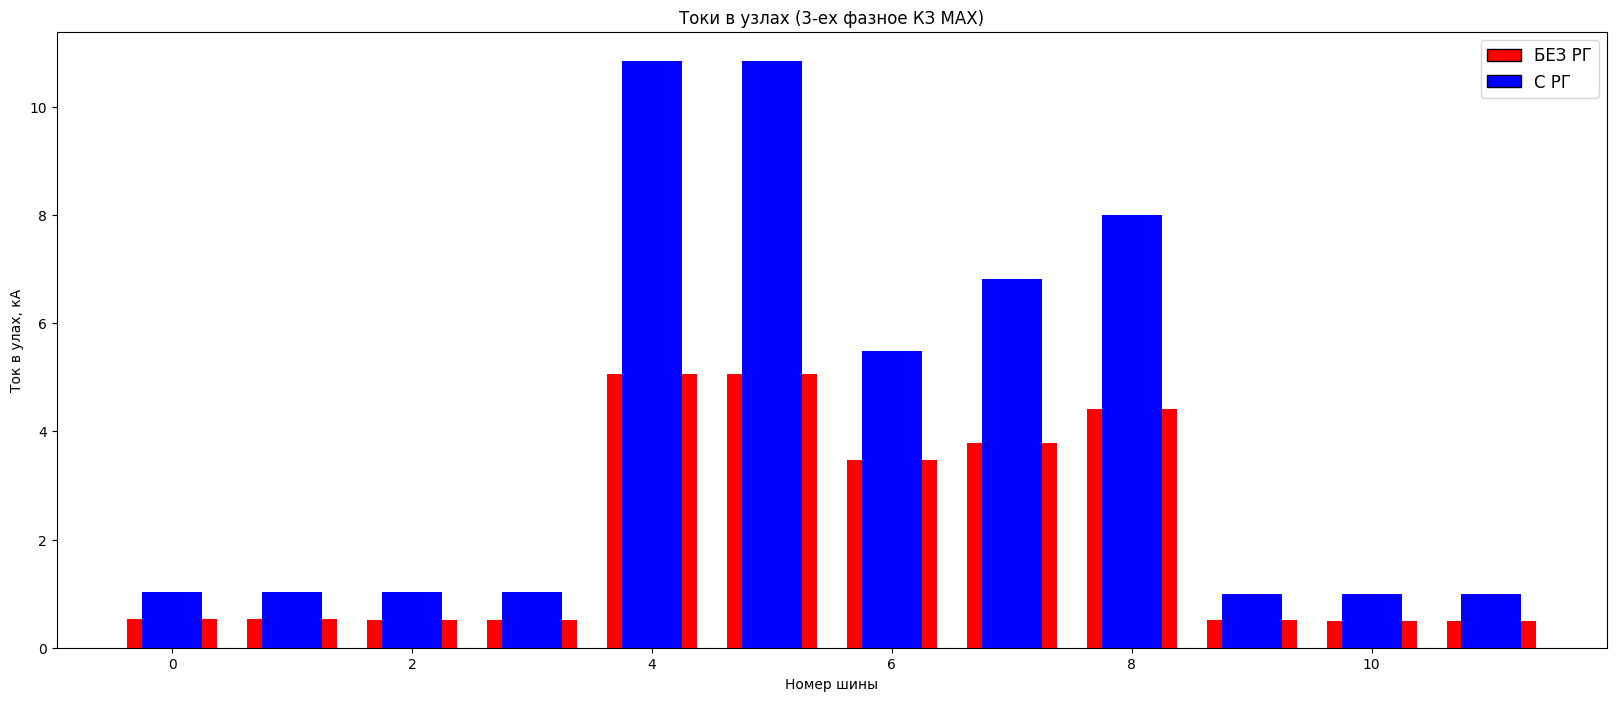

In [ ]:
#Трехфазное КЗ MAX
#Размыкаю выключатель между шинами 6 и 7
net = network(0)
sc.calc_sc(net, case="max", ip=True, ith=True, branch_results=True)

x1 = net.res_bus_sc.ikss_ka.index
y1 = net.res_bus_sc.ikss_ka

net = network(1)
sc.calc_sc(net, case="max", ip=True, ith=True, branch_results=True)

y2 = net.res_bus_sc.ikss_ka


fig,ax=plt.subplots()
ax.bar(x1,y1, width=0.75, color='red')
ax.bar(x1,y2, width=0.5, color='blue')
ax.set_facecolor('white')
fig.set_figwidth(20) #ширина
fig.set_figheight(8) #высота
fig.set_facecolor('white')

legend_elements = [plt.Rectangle((0,0), 1, 1, facecolor='red', edgecolor='black'),
                   plt.Rectangle((0,0), 1, 1, facecolor='blue', edgecolor='black')]


ax.set(title='Токи в узлах (3-ех фазное КЗ MAX)', xlabel='Номер шины', ylabel='Ток в улах, кА')
ax.legend(legend_elements, ['БЕЗ РГ', 'С РГ'], loc='upper right', fontsize=12)
plt.show()

/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)
/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)
/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprec

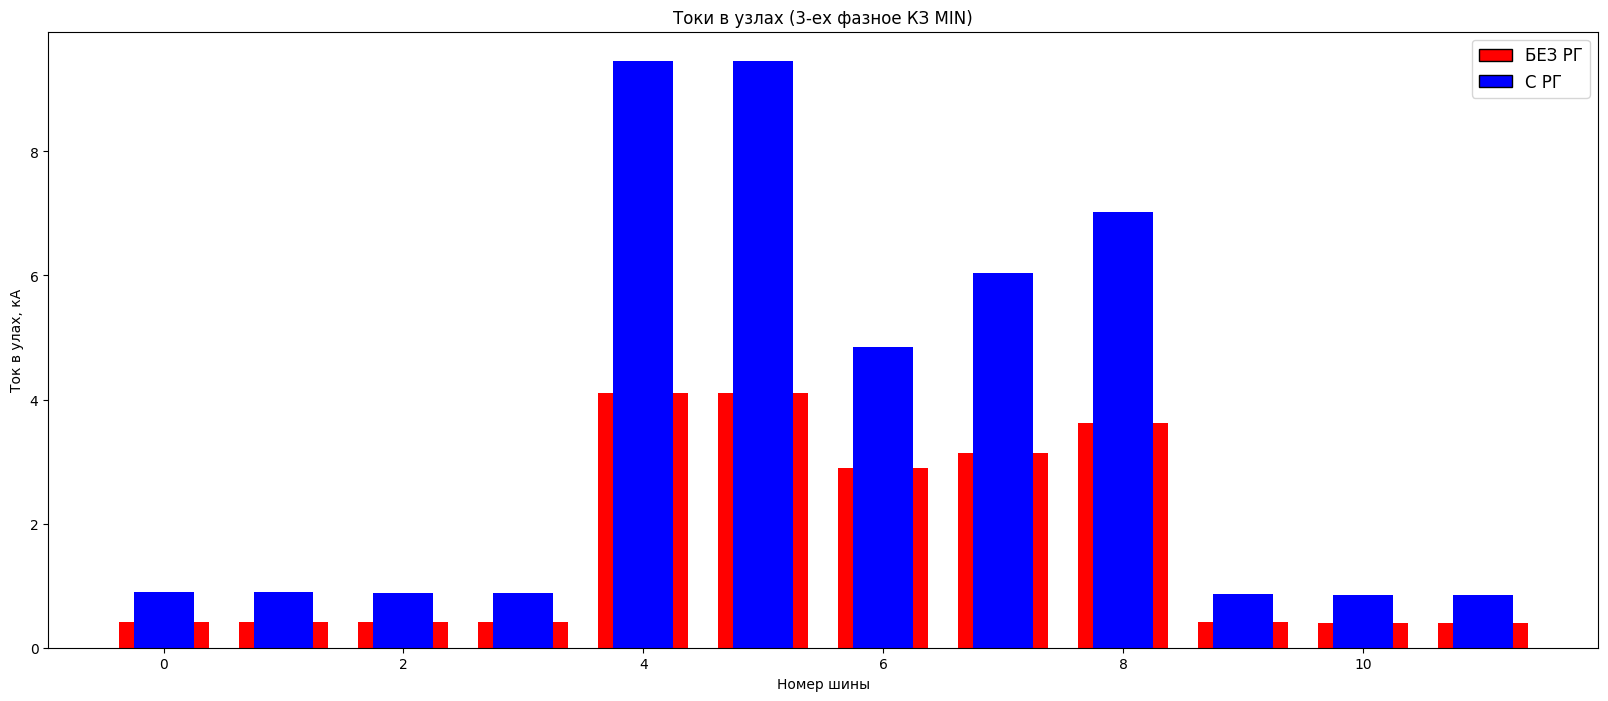

In [ ]:
#Трехфазное КЗ MIN
#Размыкаю выключатель между шинами 6 и 7
net = network(0)
net.line['endtemp_degree'] = 80
sc.calc_sc(net, case="min", ip=True, ith=True, branch_results=True)

x1 = net.res_bus_sc.ikss_ka.index
y1 = net.res_bus_sc.ikss_ka

net = network(1)
net.line['endtemp_degree'] = 80
sc.calc_sc(net, case="min", ip=True, ith=True, branch_results=True)

y2 = net.res_bus_sc.ikss_ka


fig,ax=plt.subplots()
ax.bar(x1,y1, width=0.75, color='red')
ax.bar(x1,y2, width=0.5, color='blue')
ax.set_facecolor('white')
fig.set_figwidth(20) #ширина
fig.set_figheight(8) #высота
fig.set_facecolor('white')

legend_elements = [plt.Rectangle((0,0), 1, 1, facecolor='red', edgecolor='black'),
                   plt.Rectangle((0,0), 1, 1, facecolor='blue', edgecolor='black')]


ax.set(title='Токи в узлах (3-ех фазное КЗ MIN)', xlabel='Номер шины', ylabel='Ток в улах, кА')
ax.legend(legend_elements, ['БЕЗ РГ', 'С РГ'], loc='upper right', fontsize=12)
plt.show()

/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)
/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)
/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprec

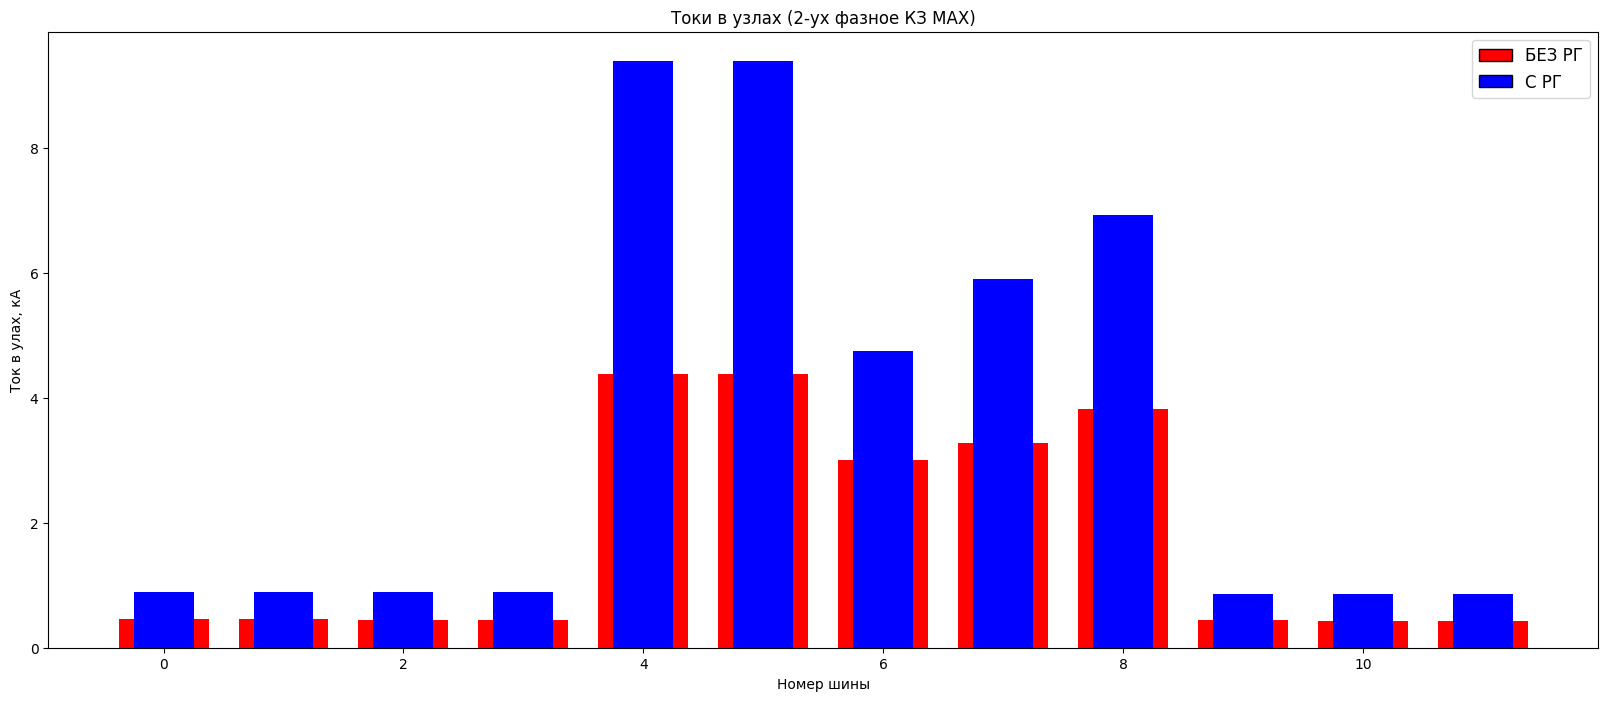

In [ ]:
#Двухфазные КЗ MAX
#Размыкаю выключатель между шинами 6 и 7
net = network(0)
sc.calc_sc(net, fault="2ph", case="max", ip=True, ith=True, branch_results=True)

x1 = net.res_bus_sc.ikss_ka.index
y1 = net.res_bus_sc.ikss_ka

net = network(1)
sc.calc_sc(net, fault="2ph", case="max", ip=True, ith=True, branch_results=True)

y2 = net.res_bus_sc.ikss_ka


fig,ax=plt.subplots()
ax.bar(x1,y1, width=0.75, color='red')
ax.bar(x1,y2, width=0.5, color='blue')
ax.set_facecolor('white')
fig.set_figwidth(20) #ширина
fig.set_figheight(8) #высота
fig.set_facecolor('white')

legend_elements = [plt.Rectangle((0,0), 1, 1, facecolor='red', edgecolor='black'),
                   plt.Rectangle((0,0), 1, 1, facecolor='blue', edgecolor='black')]


ax.set(title='Токи в узлах (2-ух фазное КЗ MAX)', xlabel='Номер шины', ylabel='Ток в улах, кА')
ax.legend(legend_elements, ['БЕЗ РГ', 'С РГ'], loc='upper right', fontsize=12)
plt.show()

/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)
/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  power_station_unit = trafo_df.power_station_unit.fillna(False).values.astype(bool)
/usr/local/lib/python3.12/dist-packages/pandapower/build_branch.py:1342: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprec

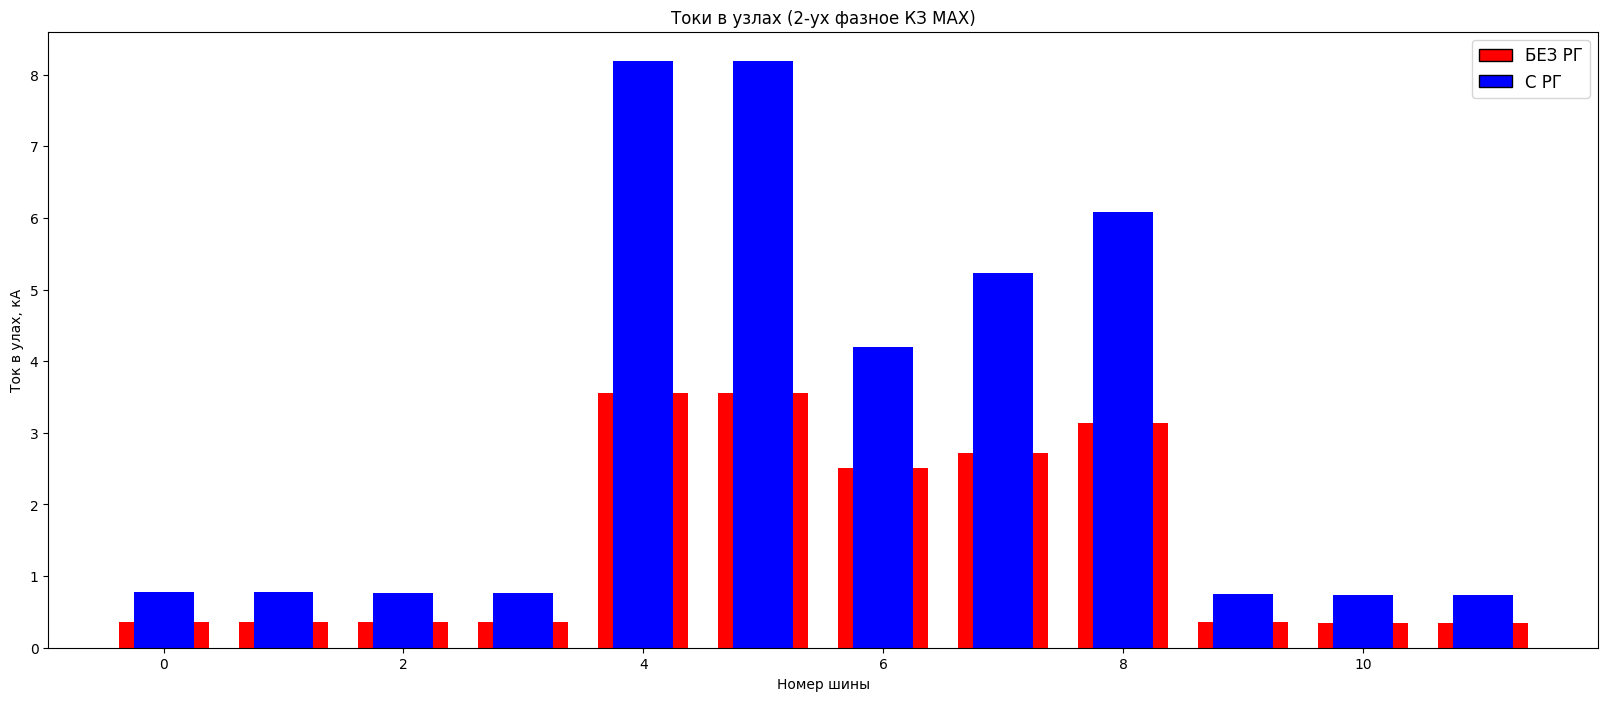

In [ ]:
#Двухфазные КЗ MIN
#Размыкаю выключатель между шинами 6 и 7
net = network(0)
net.line['endtemp_degree'] = 80
sc.calc_sc(net, fault="2ph", case="min", ip=True, ith=True, branch_results=True)

x1 = net.res_bus_sc.ikss_ka.index
y1 = net.res_bus_sc.ikss_ka

net = network(1)
net.line['endtemp_degree'] = 80
sc.calc_sc(net, fault="2ph", case="min", ip=True, ith=True, branch_results=True)

y2 = net.res_bus_sc.ikss_ka


fig,ax=plt.subplots()
ax.bar(x1,y1, width=0.75, color='red')
ax.bar(x1,y2, width=0.5, color='blue')
ax.set_facecolor('white')
fig.set_figwidth(20) #ширина
fig.set_figheight(8) #высота
fig.set_facecolor('white')

legend_elements = [plt.Rectangle((0,0), 1, 1, facecolor='red', edgecolor='black'),
                   plt.Rectangle((0,0), 1, 1, facecolor='blue', edgecolor='black')]


ax.set(title='Токи в узлах (2-ух фазное КЗ MAX)', xlabel='Номер шины', ylabel='Ток в улах, кА')
ax.legend(legend_elements, ['БЕЗ РГ', 'С РГ'], loc='upper right', fontsize=12)
plt.show()

Вывод: В ходе лабораторной работы были смоделированы токи короткого замыкания, протекающие в узлах электрической сети c распределенной генерацией и без неё, при трёхфазном и двухфазном КЗ, при максимальной и минимальной мощности. По экспериментальным данным было установлено, что в любых случаях ток короткого замыкания, протекающий в узлах электрической сети, будет больше при наличии распределенной генерации.